In [1]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset
from matplotlib import pyplot as plt
import transformers

torch.set_grad_enabled(False)
# model_name = "gpt2-xl"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
# mt = ModelAndTokenizer(
#     model_name,
#     torch_dtype=(torch.float16 if "20b" in model_name else None),
# )

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

mt = transformers.pipeline(
  "text-generation",
  model="meta-llama/Meta-Llama-3-8B-Instruct",
  model_kwargs={"torch_dtype": torch.bfloat16},
  device="cuda",
)

predict_token(
    mt,
    ["The Eiffel Tower is in the heart of", "The Space Needle is in the city of"],
    return_p=True,
)
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername, granularity) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
    granularity=100,  # The granularity of restoration
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l, g in states_to_patch:
        patch_spec[l].append((t, g))
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t, g in patch_spec[layer]:
            h[1:, t, g*granularity:(g+1)*granularity] = h[0, t, g*granularity:(g+1)*granularity]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

def trace_important_states(model, num_layers, inp, e_range, answer_t, granularity=100, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layer_scores = []
            for g in range(model.config.hidden_size // granularity):
                r = trace_with_patch(
                    model,
                    inp,
                    [(tnum, layername(model, layer), g)],
                    answer_t,
                    tokens_to_mix=e_range,
                    noise=noise,
                    granularity=granularity,
                )
                layer_scores.append(r)
            row.append(torch.stack(layer_scores))
        table.append(torch.stack(row))
    return torch.stack(table)

def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1, granularity=100
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layer_scores = []
            for g in range(model.config.hidden_size // granularity):
                layerlist = [
                    (tnum, layername(model, L, kind), g)
                    for L in range(
                        max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                    )
                ]
                r = trace_with_patch(
                    model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise, granularity=granularity
                )
                layer_scores.append(r)
            row.append(torch.stack(layer_scores))
        table.append(torch.stack(row))
    return torch.stack(table)

def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None, granularity=100
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise, granularity=granularity
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, 32, inp, e_range, answer_t, noise=noise, granularity=granularity
        )
    else:
        differences = trace_important_window(
            mt.model,
            32,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
            granularity=granularity
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
        granularity=granularity,
    )

def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
    granularity=100,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind, granularity=granularity
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)
    return result




def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"
        # 获取张量的形状
    token_size, dim1, dim2 = differences.size()

    # 将最后两个维度展平
    differences = differences.view(token_size, dim1 * dim2)
    
    with plt.rc_context():
        fig, ax = plt.subplots(figsize=(14, 8))
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels)
        if not modelname:
            modelname = "LLAMA"
        if not kind:
            ax.set_title("Impact of restoring state after corrupted input")
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "attn"
            ax.set_title(f"Impact of restoring {kindname} after corrupted input")
            ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
        # savepdf =   f"./output/hidden_flow_{kind}_{window}_{result['granularity']}.pdf"
            
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()
            

def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None, granularity=100):
    results = []
    for kind in [None, "mlp", "attn"]:
        result = plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind, granularity=granularity
        )
        results.append(result["scores"]) 
    return results   

# Eiffel = plot_all_flow(mt, "The Eiffel Tower is in the heart of", noise=noise_level, granularity=4096)


/home/ljc/miniconda3/envs/fw/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded dataset with 1209 elements
Using noise level 0.023345947265625


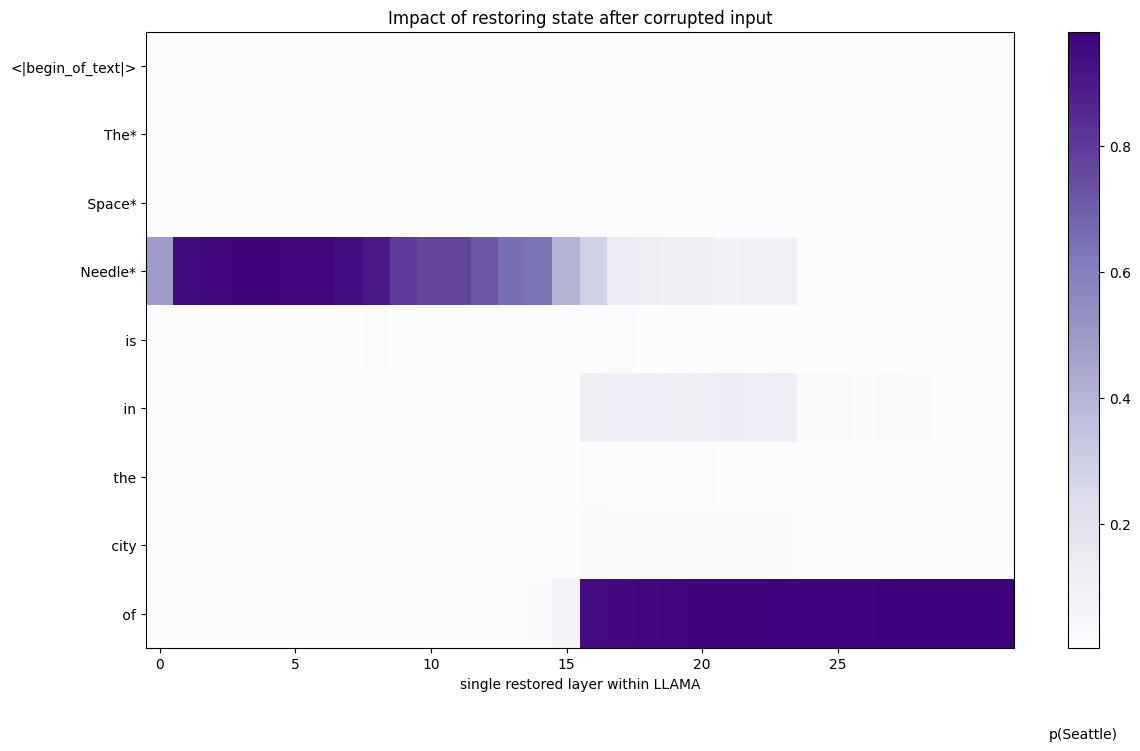

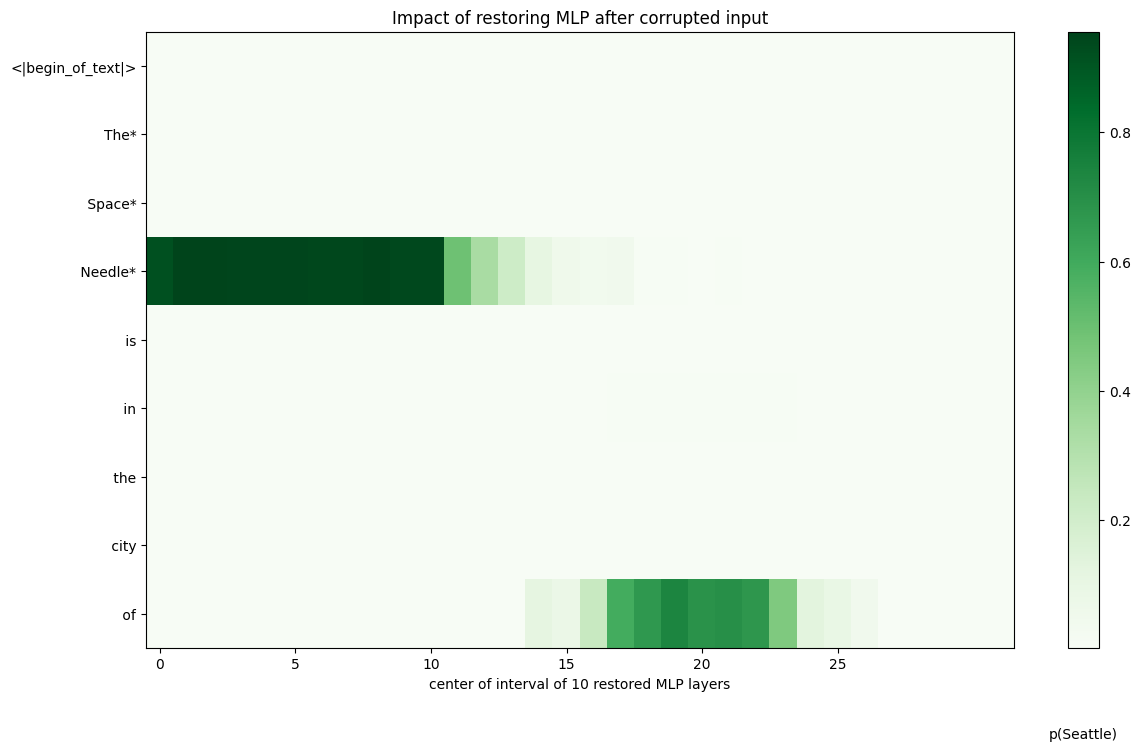

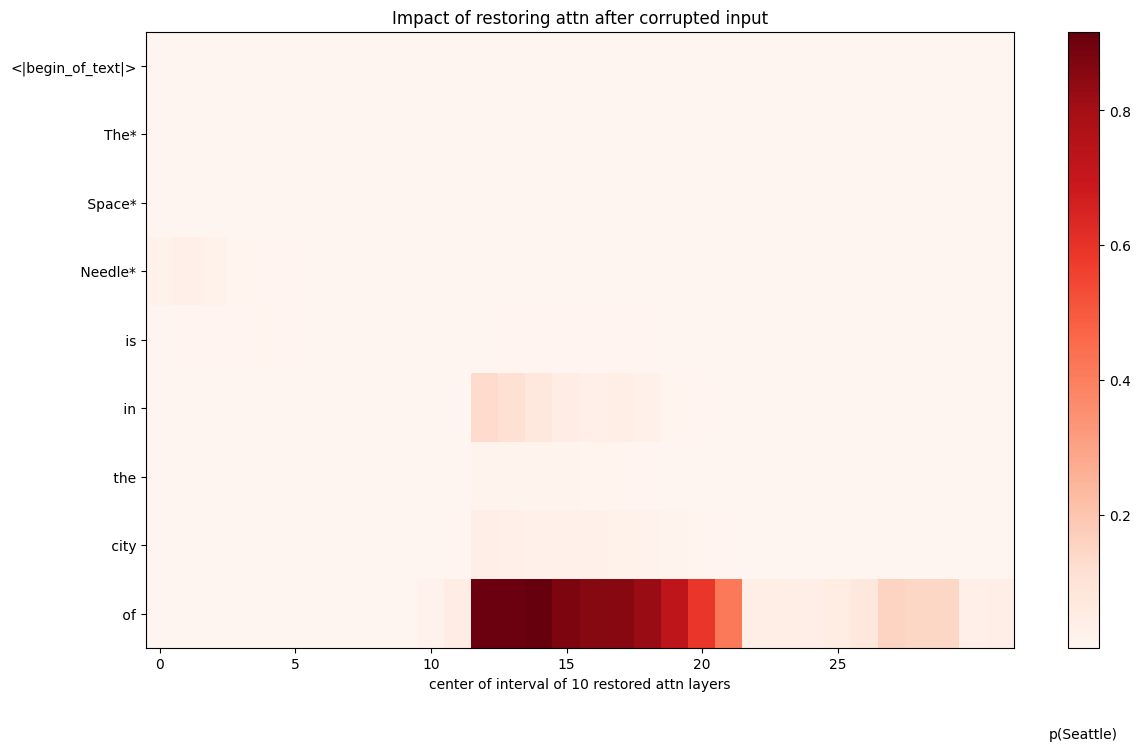

In [2]:
# Example call with granularity
Needle_origin = plot_all_flow(mt, "The Space Needle is in the city of", noise=noise_level, granularity=4096)

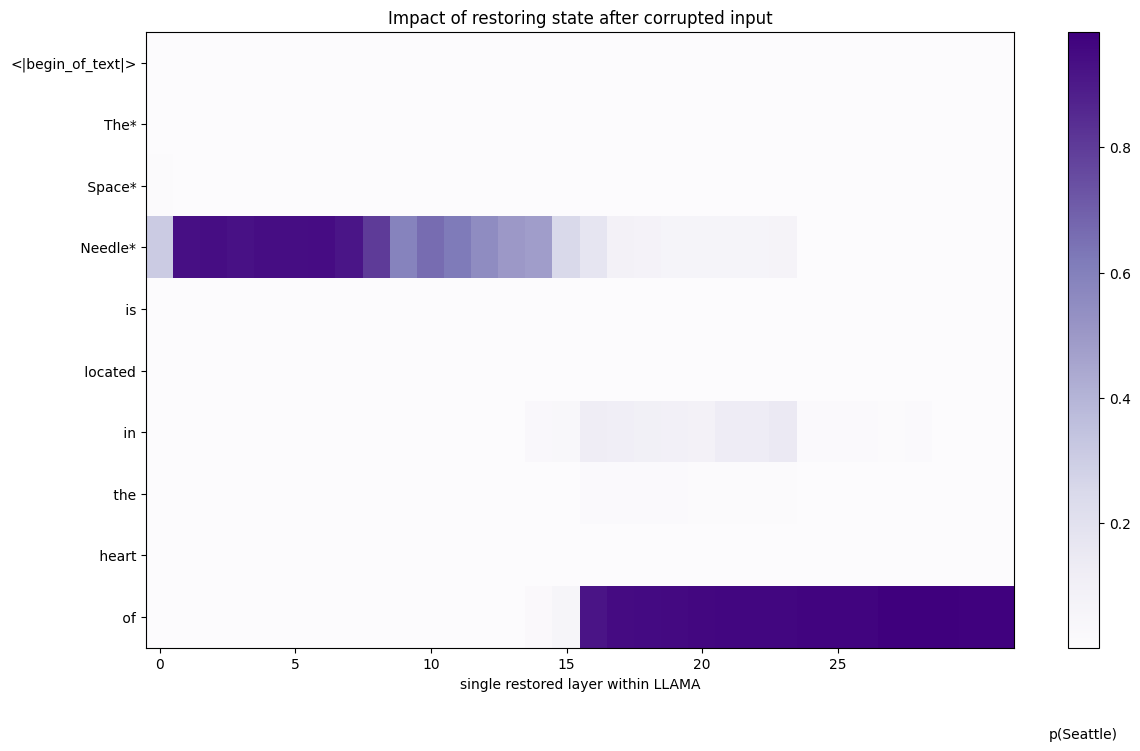

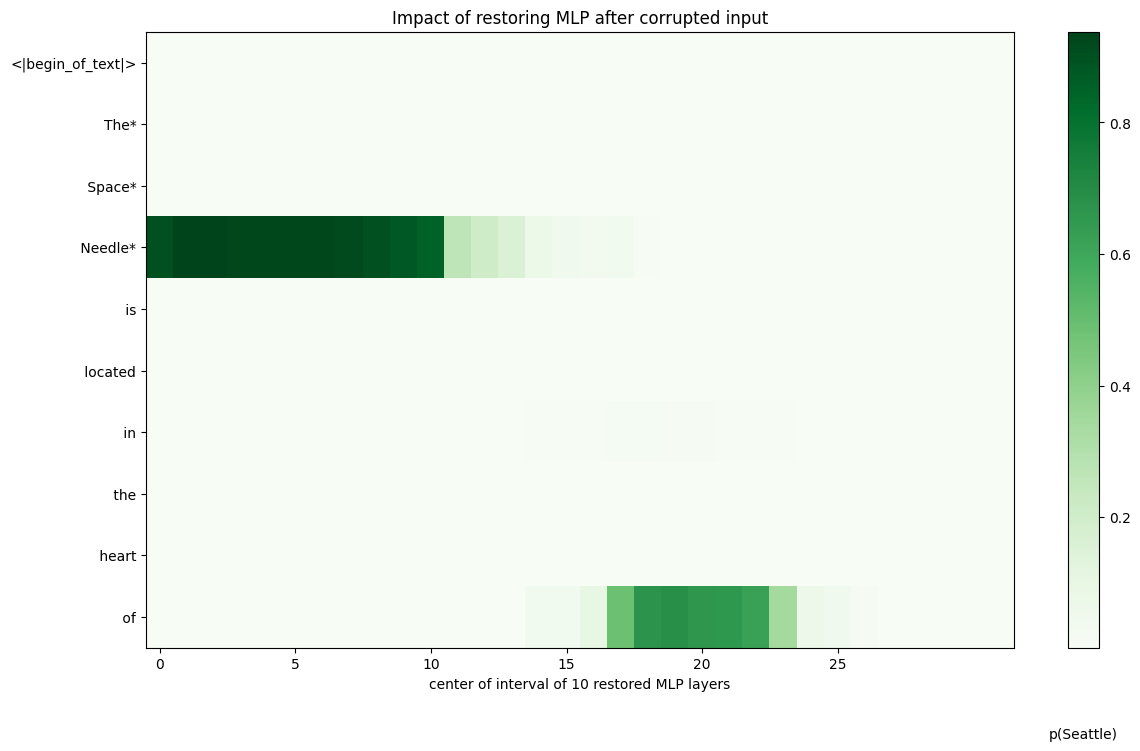

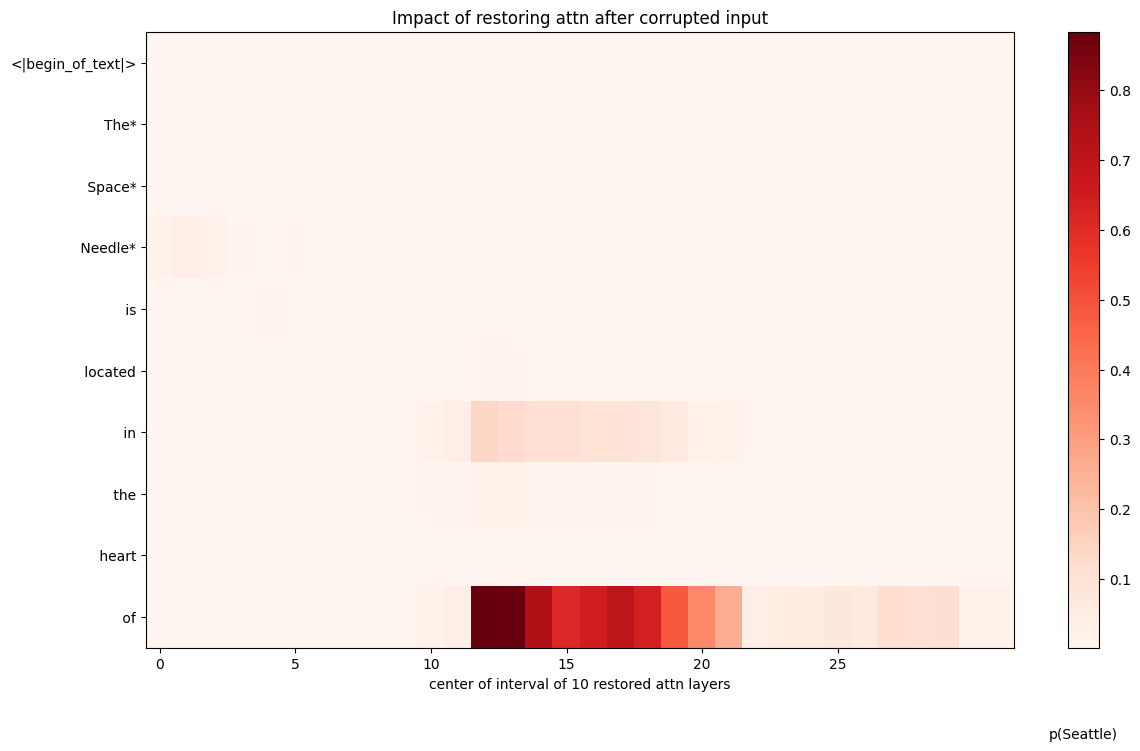

In [3]:
Needle_near = plot_all_flow(mt, "The Space Needle is located in the heart of", noise=noise_level, granularity=4096)

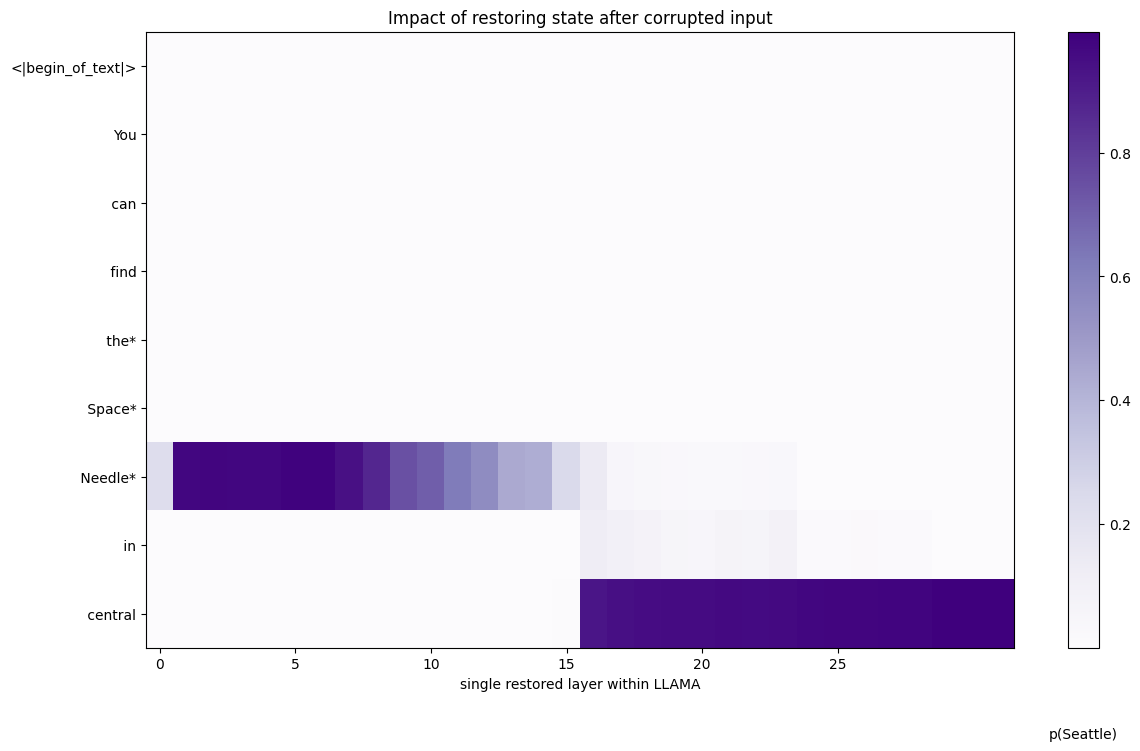

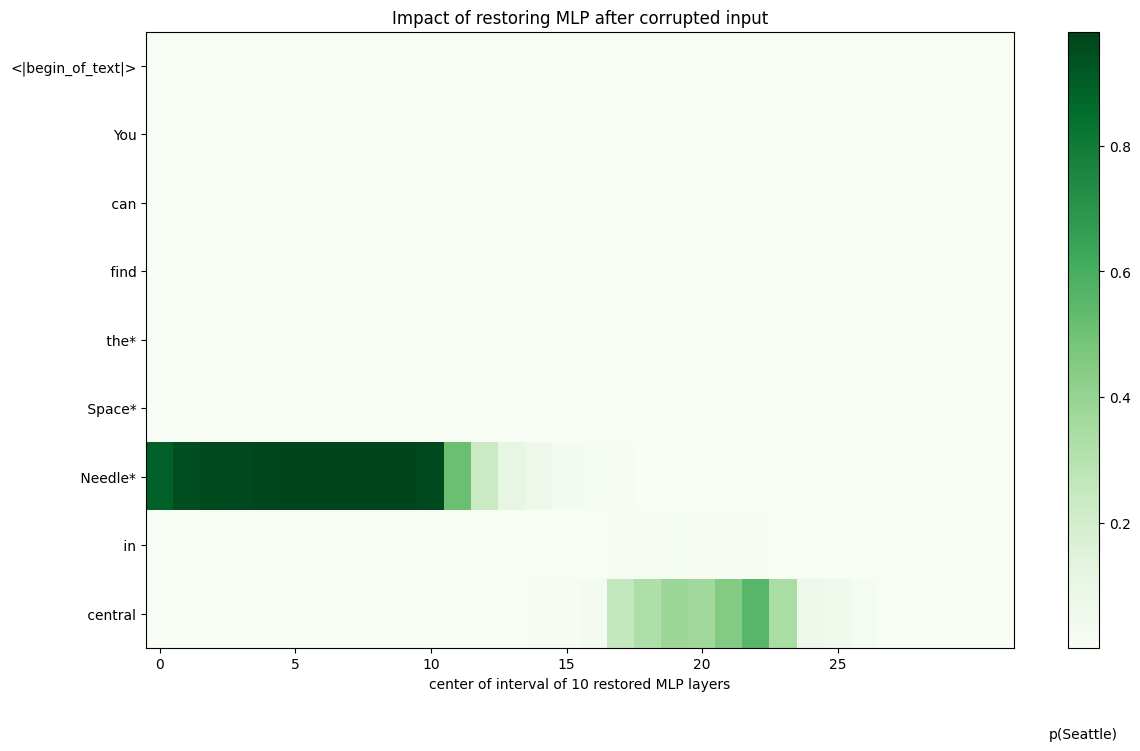

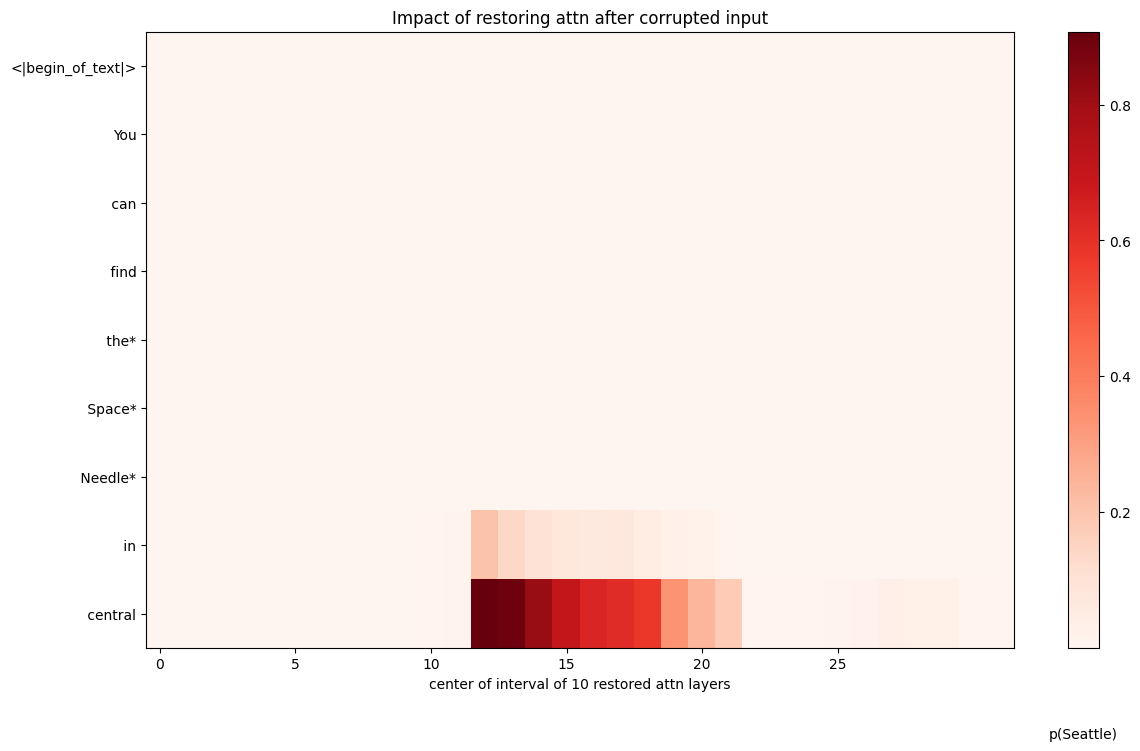

In [4]:
Needle_far = plot_all_flow(mt, "You can find the Space Needle in central", noise=noise_level, granularity=4096,subject="the Space Needle")

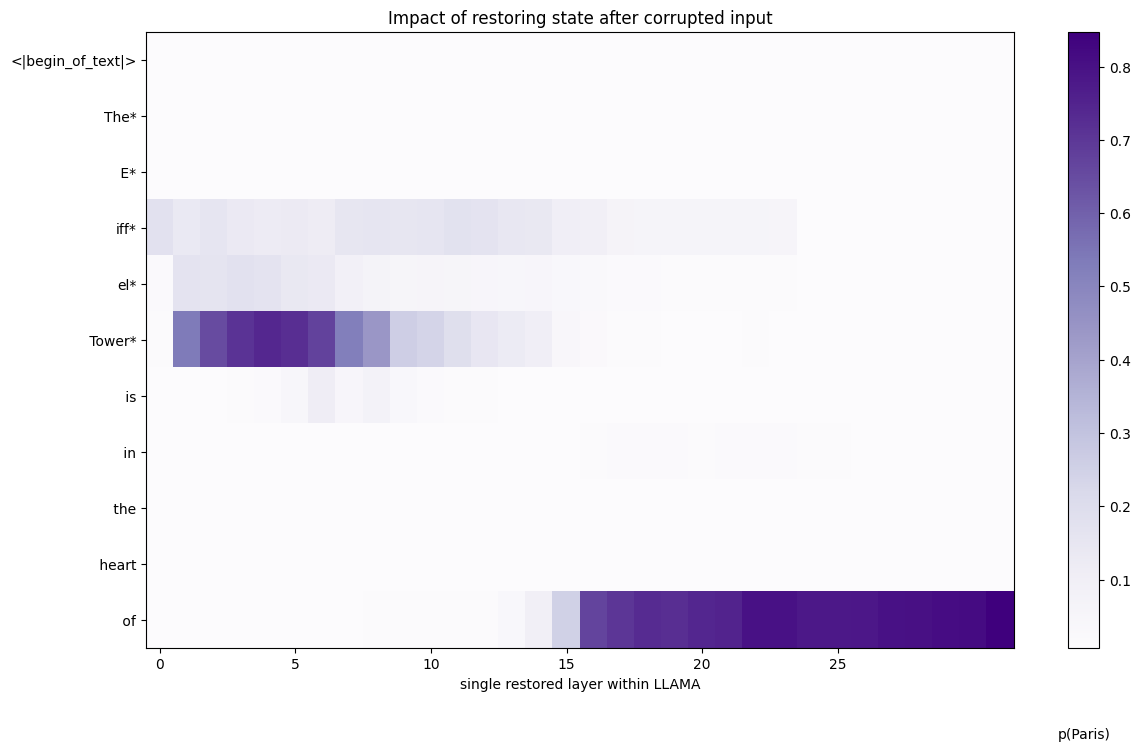

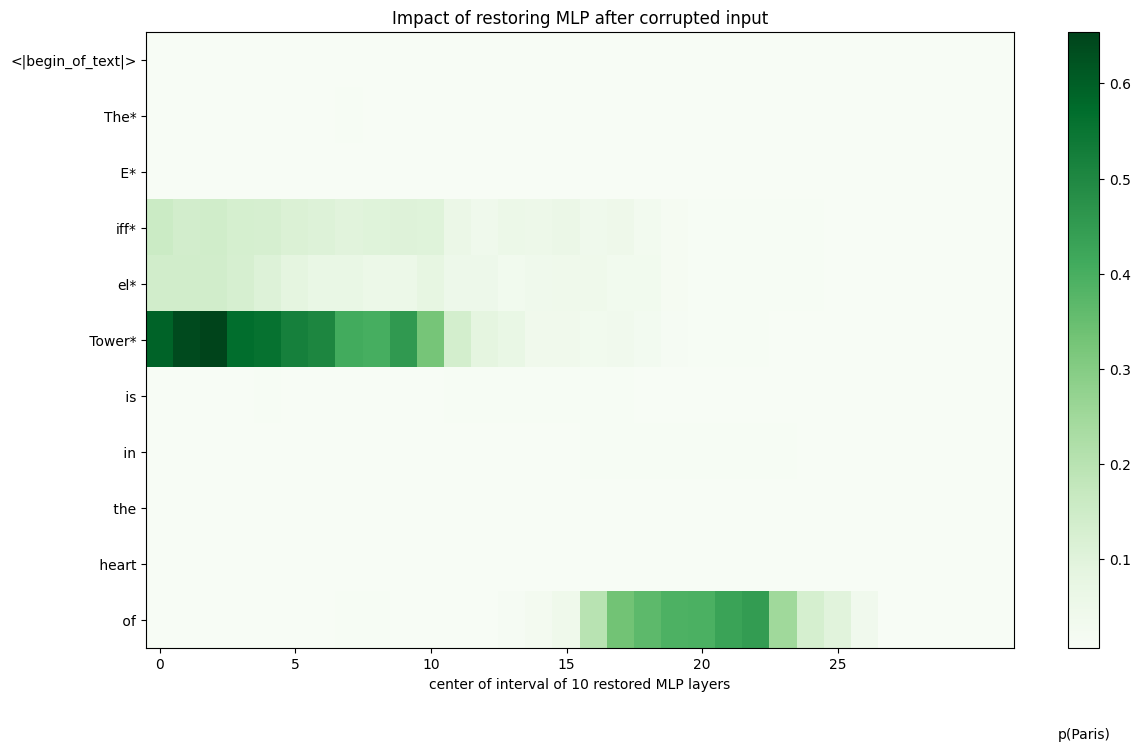

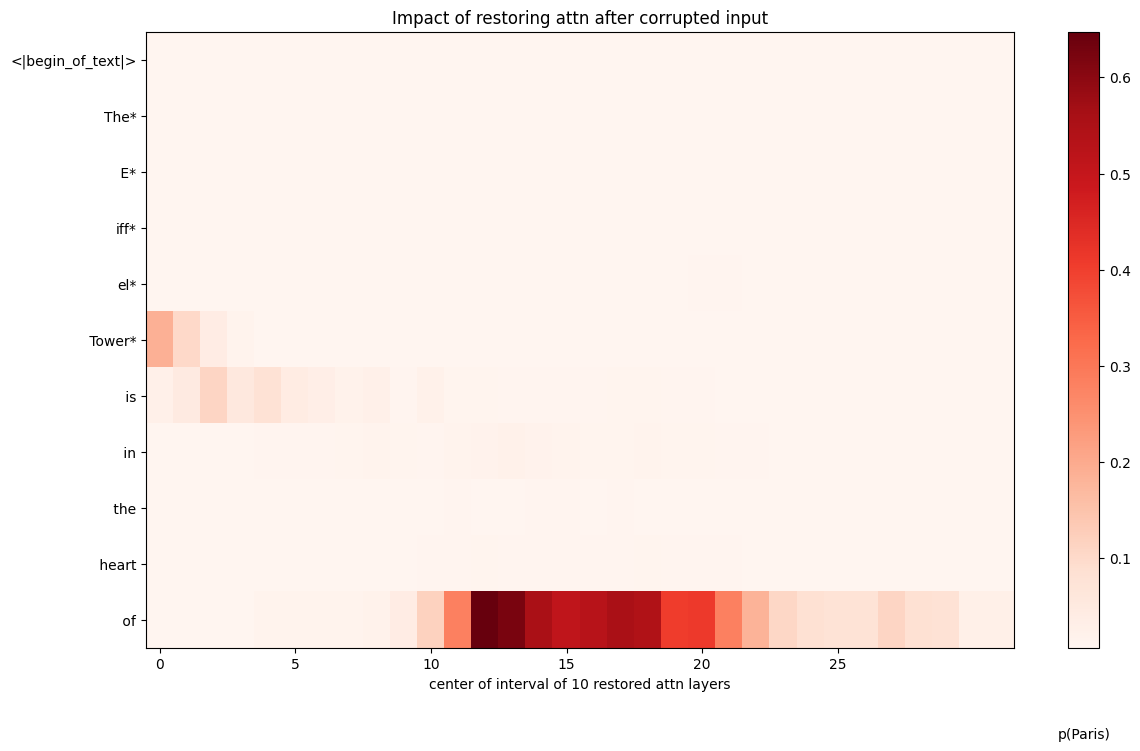

In [5]:
Eiffel = plot_all_flow(mt, "The Eiffel Tower is in the heart of", noise=noise_level, granularity=4096)

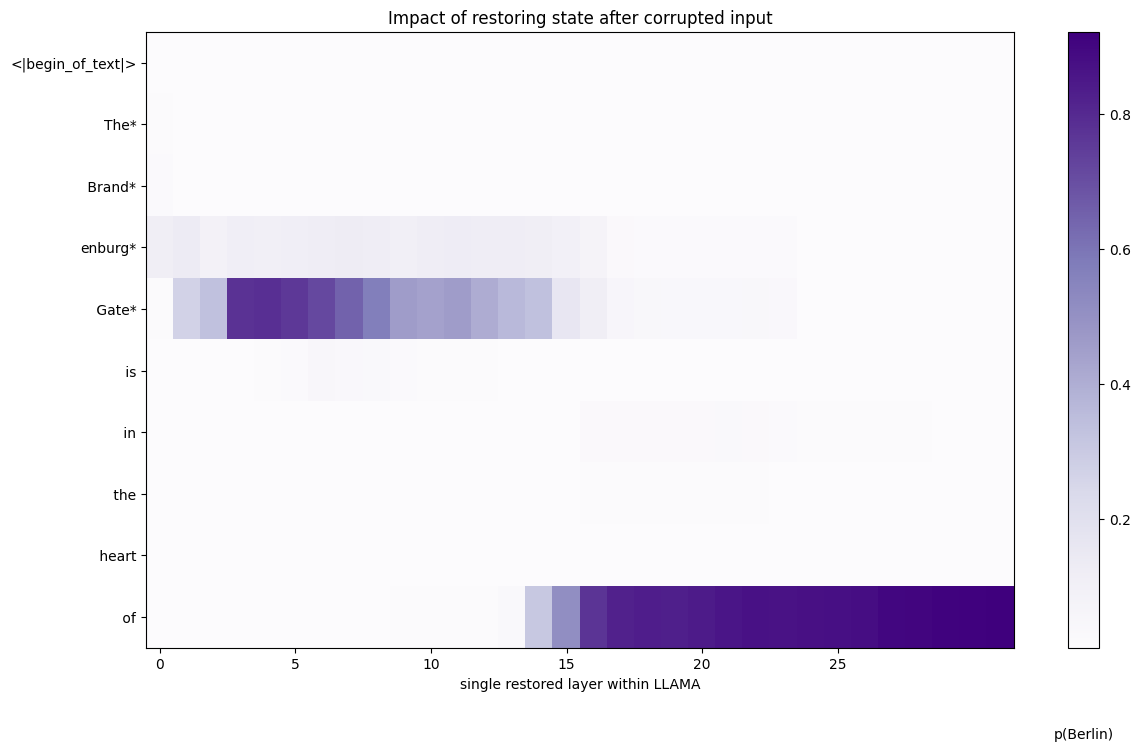

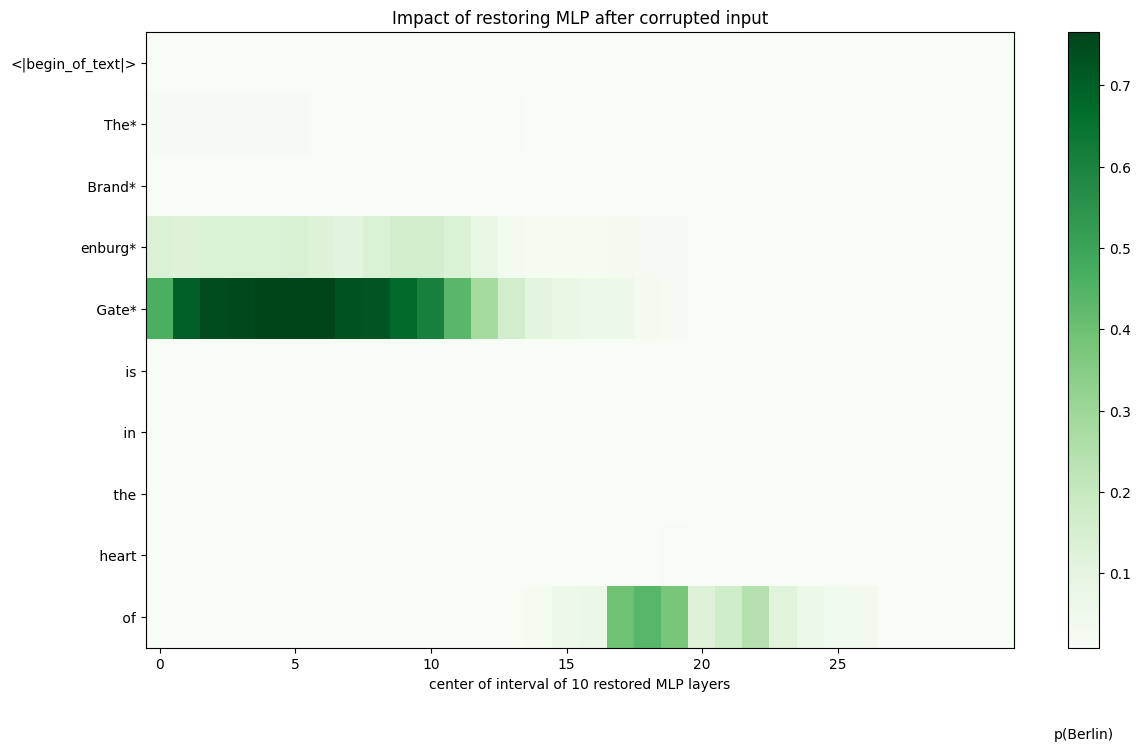

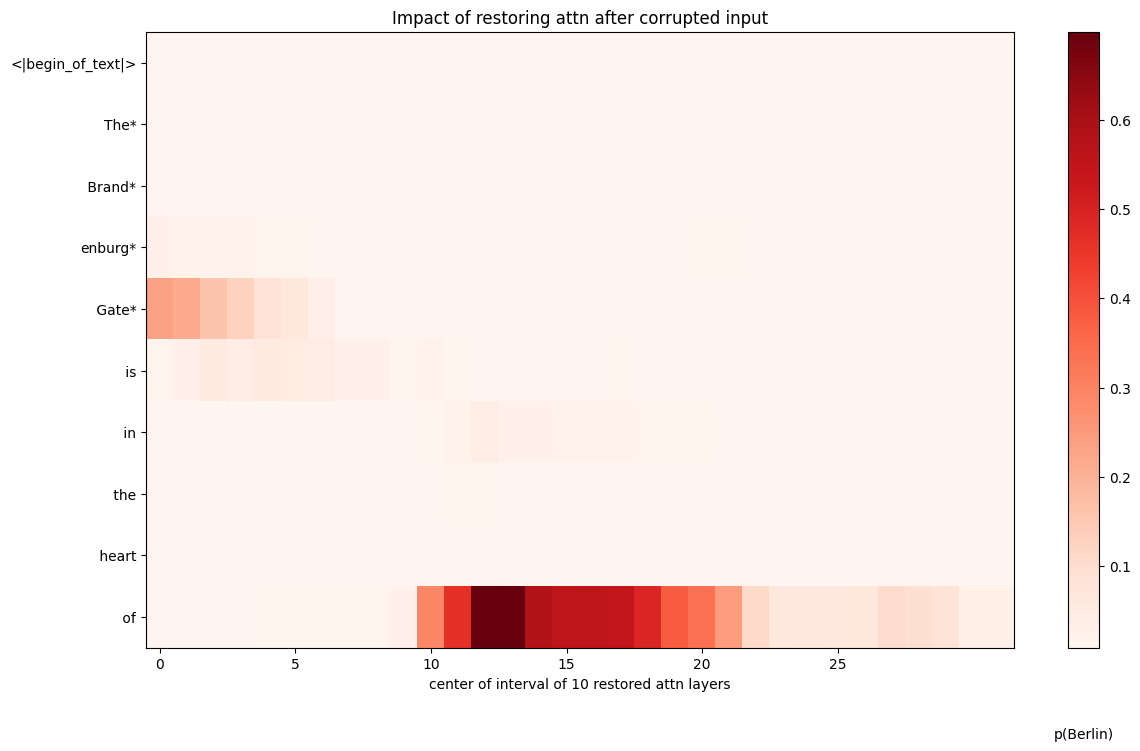

In [6]:

Berlin = plot_all_flow(mt, "The Brandenburg Gate is in the heart of", noise=noise_level, granularity=4096,subject="The Brandenburg Gate")

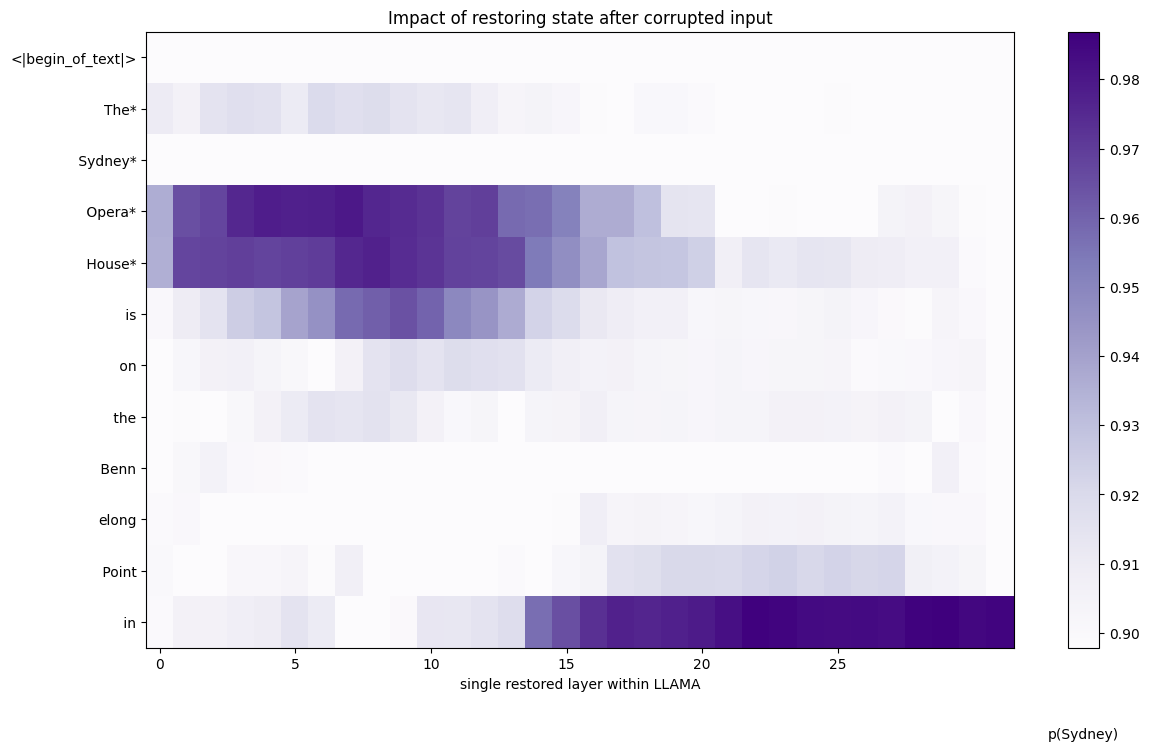

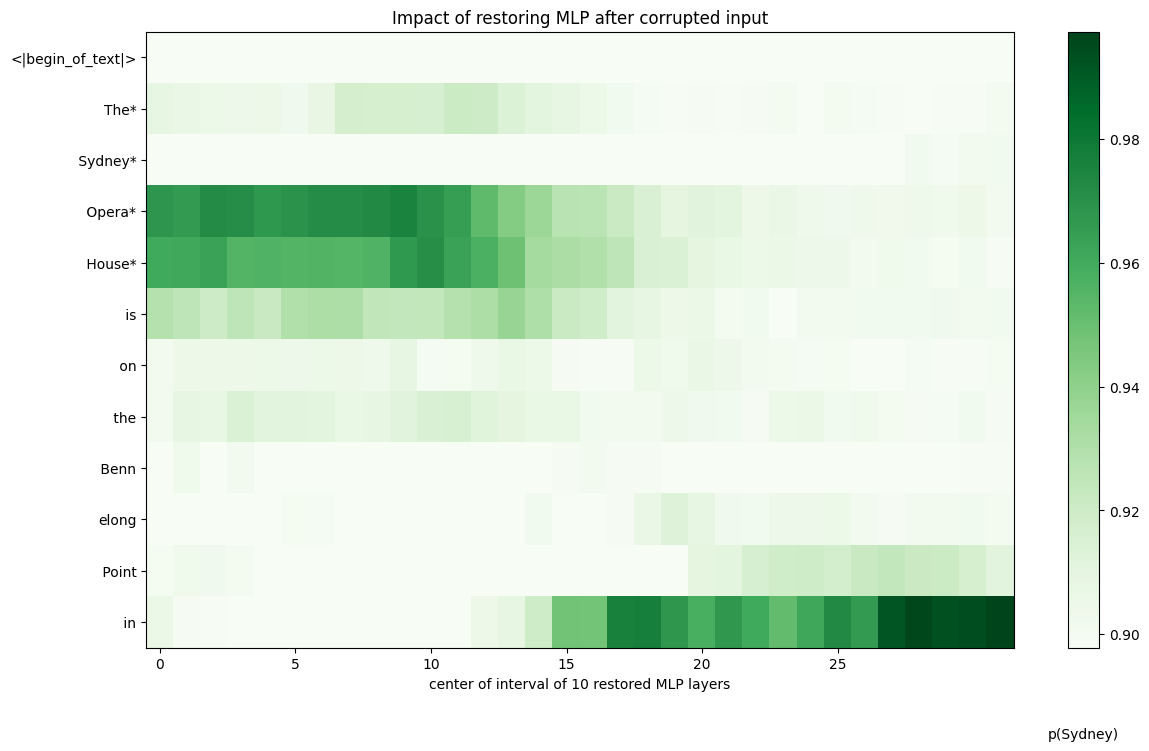

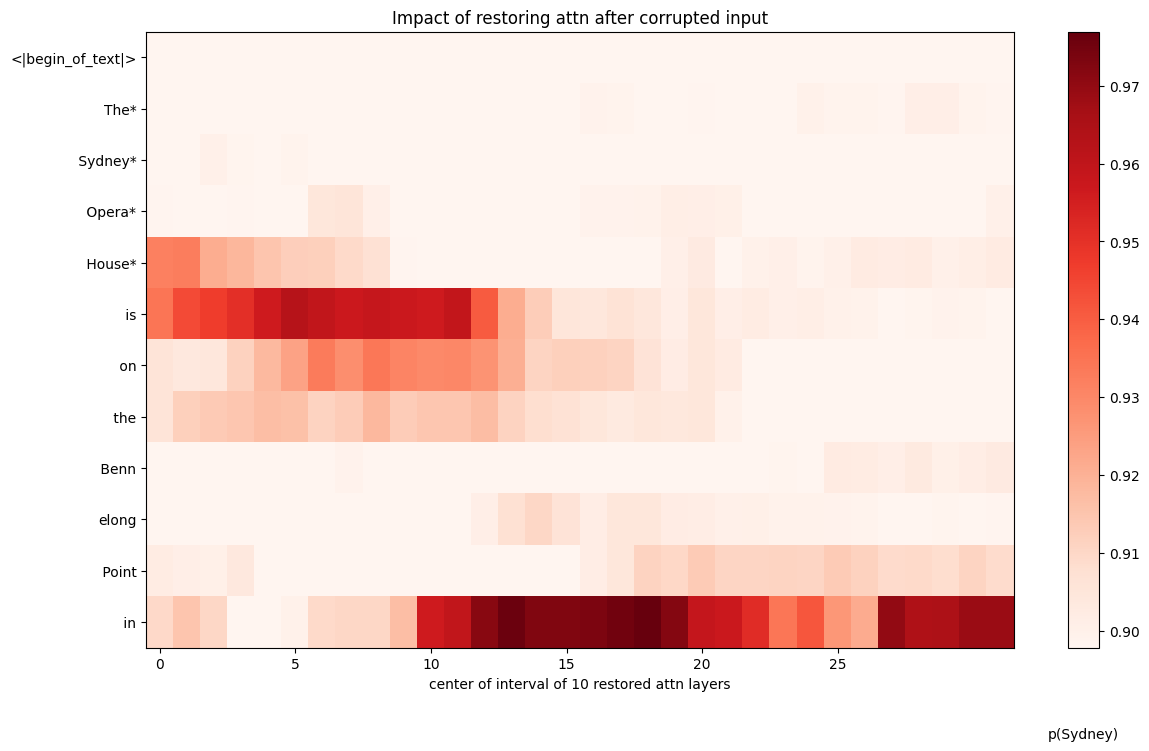

In [7]:
Sydney = plot_all_flow(mt, "The Sydney Opera House is on the Bennelong Point in", noise=noise_level, granularity=4096,subject="The Sydney Opera House")

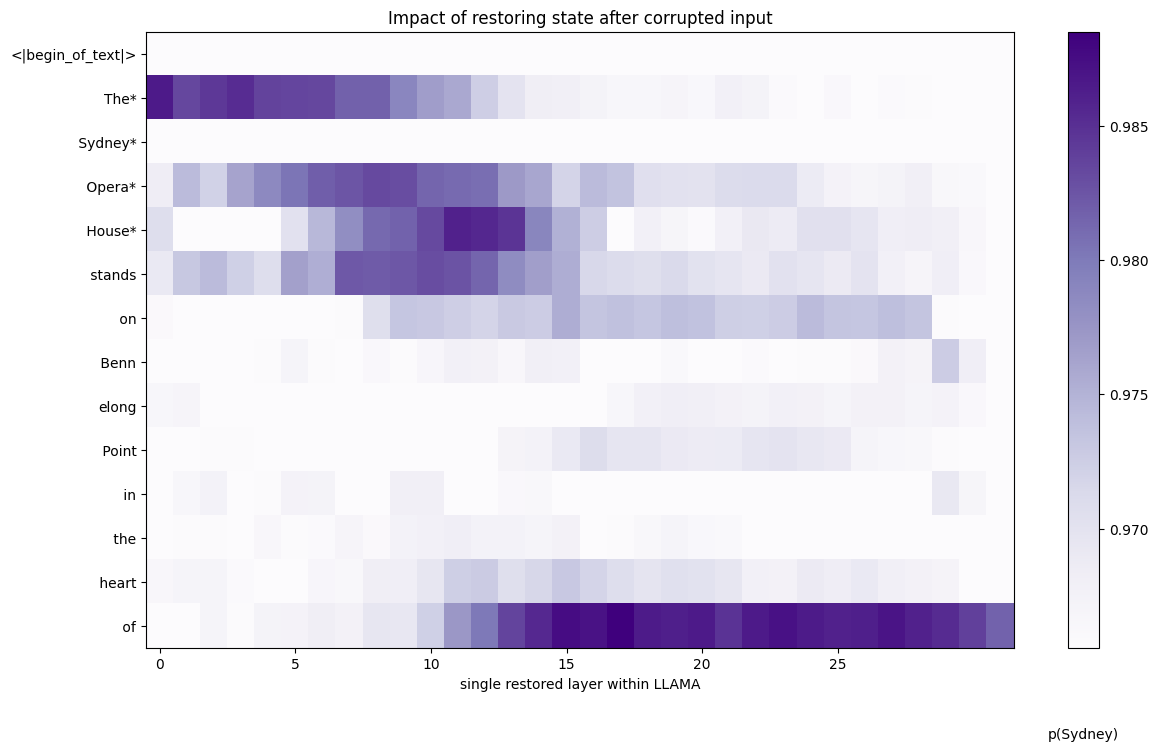

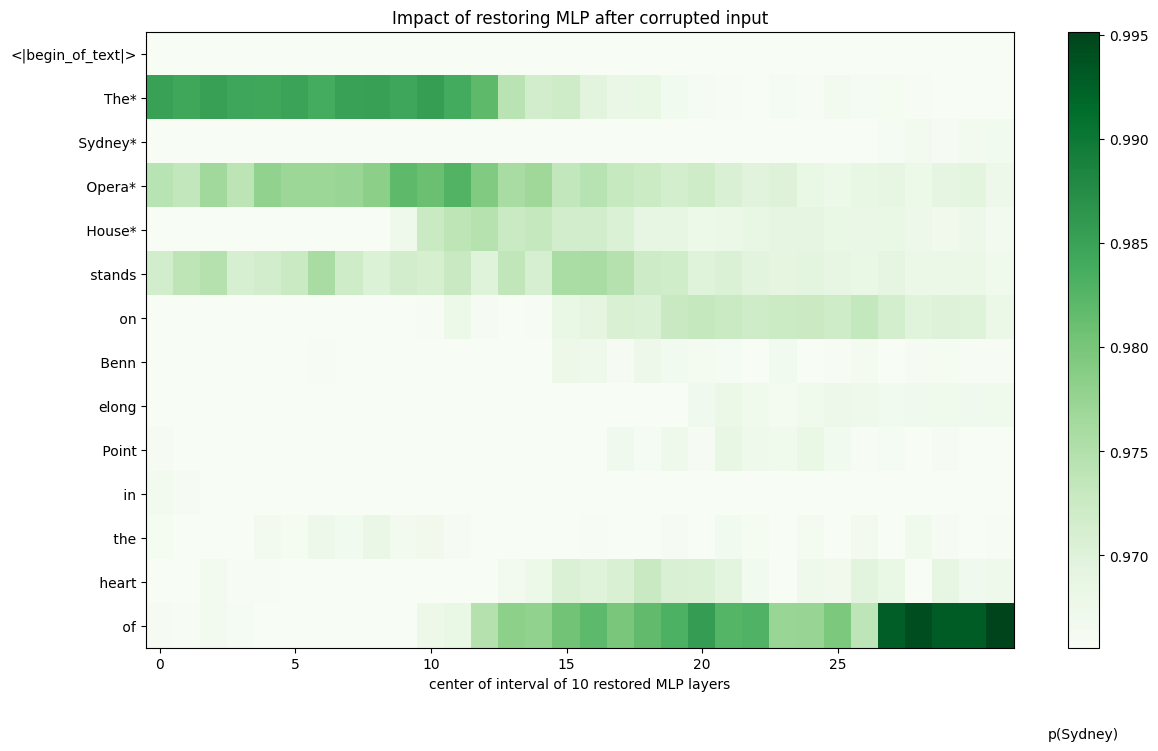

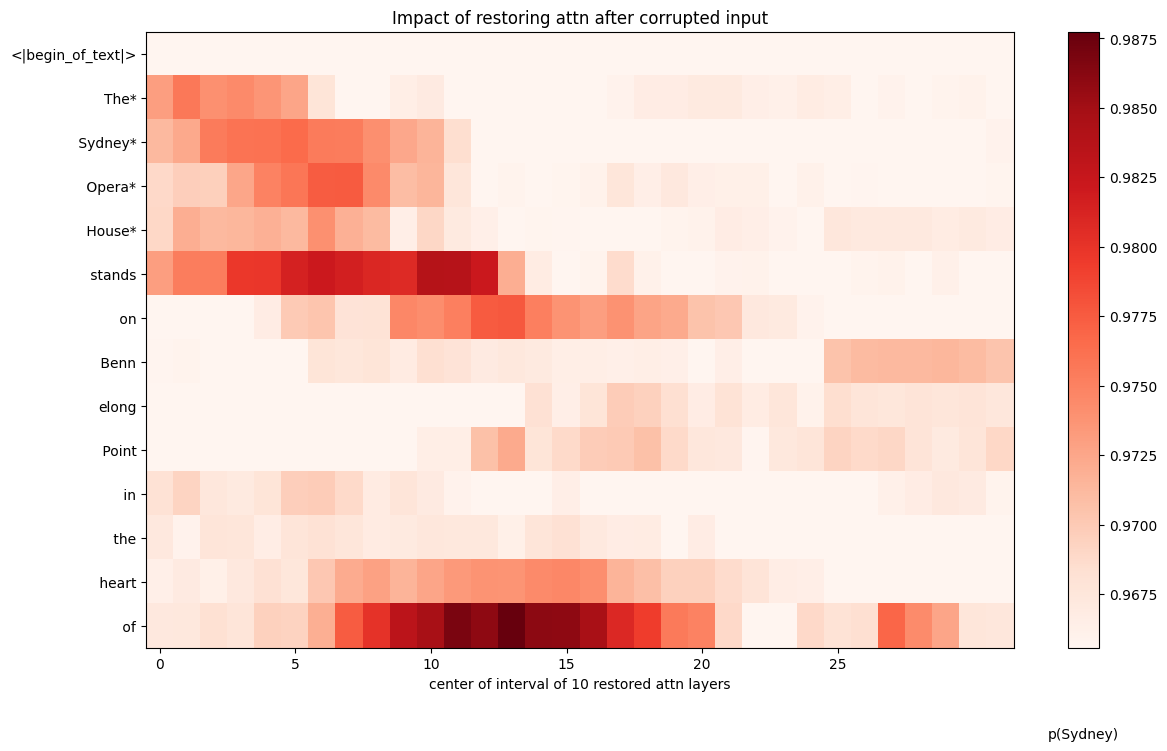

In [8]:
Sydney_near = plot_all_flow(mt, "The Sydney Opera House stands on Bennelong Point in the heart of", noise=noise_level, granularity=4096,subject="The Sydney Opera House")

In [9]:
predict_token(
    mt,
    ["You can find the Sydney Opera House at Bennelong Point in the"],
    return_p=True,
)

([' heart'], tensor([0.4727], device='cuda:0'))

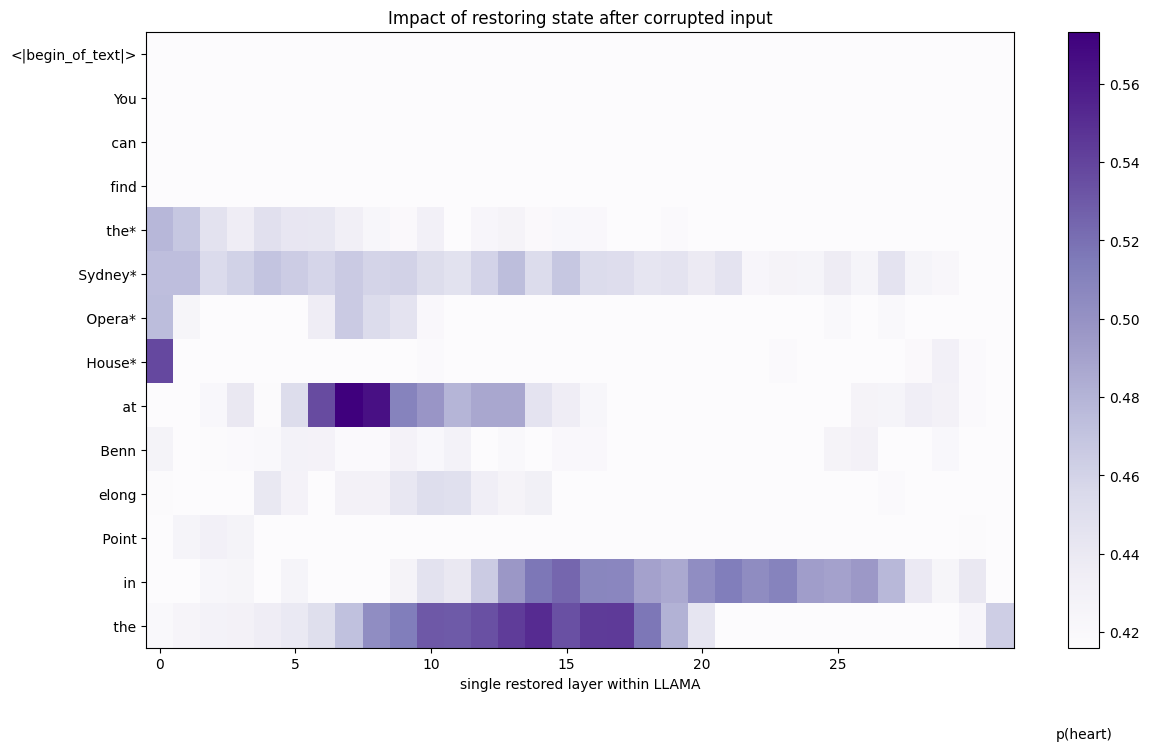

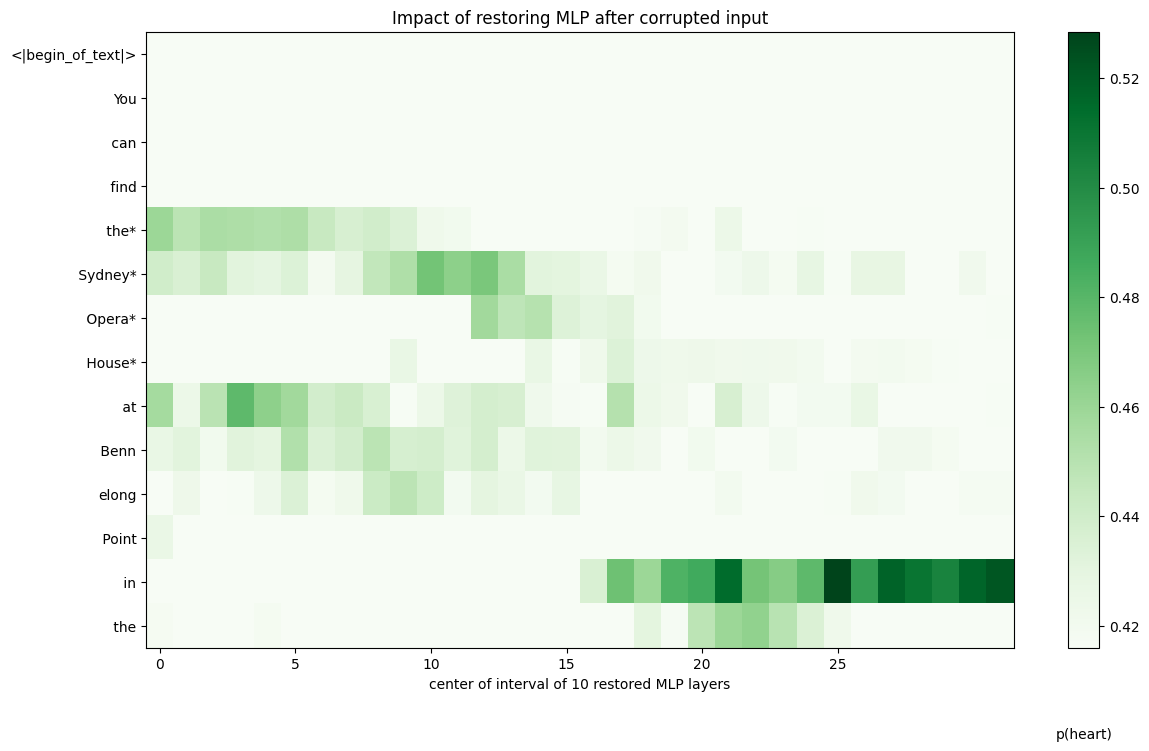

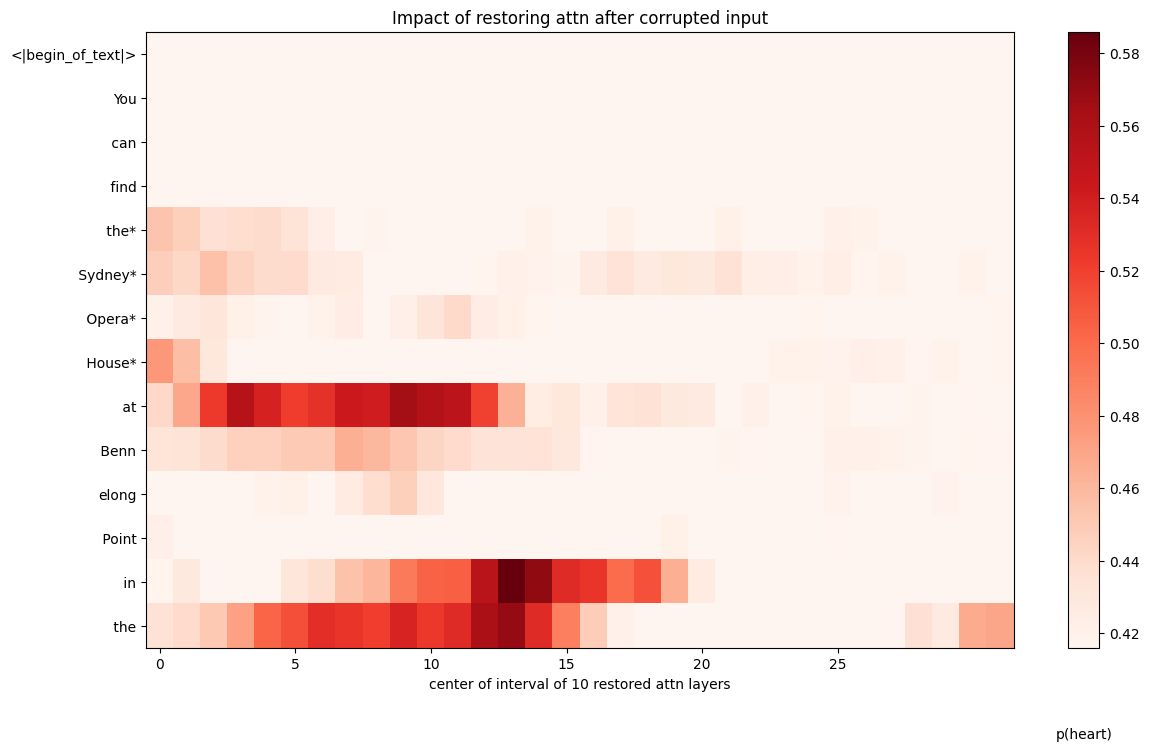

In [10]:
Sydney_far = plot_all_flow(mt, "You can find the Sydney Opera House at Bennelong Point in the", noise=noise_level, granularity=4096,subject="the Sydney Opera House")

In [16]:
import numpy as np
def normalize(tensor):
    return tensor / torch.norm(tensor)

def plot_point(r1, r2, title=None):
        # 将 PyTorch 张量转换为 NumPy 数组
    if torch.is_tensor(r1):
        r1_np = r1.numpy()
        r2_np = r2.numpy()
    else:
        r1_np = r1
        r2_np = r2

    # x 轴为 48 layers
    layers = np.arange(1, 33)

    # 创建一个图形，并指定大小
    plt.figure(figsize=(4, 2))

    # 绘制 r1 和 r2 的折线图
    plt.plot(layers, r1_np, label='r1', marker='o')
    plt.plot(layers, r2_np, label='r2', marker='x')

    # 添加标题和标签
    plt.title(title)
    plt.xlabel('Layers')
    plt.ylabel('Values')

    # 添加图例
    plt.legend()

    # 显示网格
    plt.grid(True)

    # 显示图形
    plt.show()
    
def calculate_distances(r1, r2):
    plot_point(r1, r2, title='Original')
    # Normalize the vectors
    r1 = normalize(r1)
    r2 = normalize(r2)
    plot_point(r1, r2, title='Normalization')
    
    distances = {}

    # Euclidean Distance
    euclidean_distance = torch.norm(r1 - r2)
    distances['EuclideanDistance↓'] = euclidean_distance.item()

    # Manhattan Distance
    manhattan_distance = torch.sum(torch.abs(r1 - r2))
    distances['ManhattanDistance↓'] = manhattan_distance.item()

    # Cosine Similarity
    cosine_similarity = torch.nn.functional.cosine_similarity(r1, r2, dim=0)
    distances['CosineSimilarity↑'] = cosine_similarity.item()

    # Chebyshev Distance
    chebyshev_distance = torch.max(torch.abs(r1 - r2))
    distances['ChebyshevDistance↓'] = chebyshev_distance.item()

    # Minkowski Distance (p=3)
    p = 3
    minkowski_distance = torch.norm(r1 - r2, p=p)
    distances[f'MinkowskiDistance(p={p})↓'] = minkowski_distance.item()

    # Formatting the output
    distance_names = ','.join(distances.keys())
    distance_values = ','.join(f"{value:.4f}" for value in distances.values())

    print(distance_names)
    print(distance_values)

In [17]:
import torch
import numpy as np
from scipy.stats import pearsonr, spearmanr
from dtaidistance import dtw

def calculate_corr(r1, r2):
    # 将 PyTorch 张量转换为 NumPy 数组
    r1_np = r1.numpy()
    r2_np = r2.numpy()

    # 2. Standardization
    r1_normalized = (r1_np - np.mean(r1_np)) / np.std(r1_np)
    r2_normalized = (r2_np - np.mean(r2_np)) / np.std(r2_np)

    # 确保它们是 1-D 向量
    r1_normalized = r1_normalized.flatten()
    r2_normalized = r2_normalized.flatten()

    # 确保它们是 1-D 向量
    assert r1_normalized.ndim == 1, "r1_normalized is not a 1-D vector"
    assert r2_normalized.ndim == 1, "r2_normalized is not a 1-D vector"

    # 计算皮尔逊相关系数
    pearson_corr, _ = pearsonr(r1_normalized, r2_normalized)

    # 计算斯皮尔曼秩相关系数
    spearman_corr, _ = spearmanr(r1_normalized, r2_normalized)

    # 计算 DTW 距离
    dtw_distance = dtw.distance(r1_normalized, r2_normalized)

    # 计算均方误差
    mse = np.mean((r1_normalized - r2_normalized)**2)

    # 存储结果到字典
    results = {
        "PearsonCorrelation↑": pearson_corr,
        "SpearmanCorrelation↑": spearman_corr,
        "DTWDistance↓": dtw_distance,
        "MeanSquaredError↓": mse
    }

    names = ','.join(results.keys())
    values = ','.join(f"{value:.4f}" for value in results.values())

    print(names)
    print(values)


torch.Size([32]) torch.Size([32])
Origin vs Near


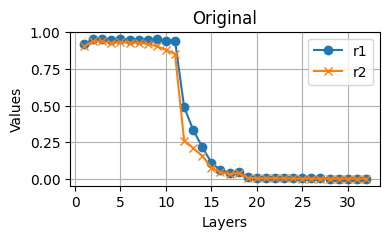

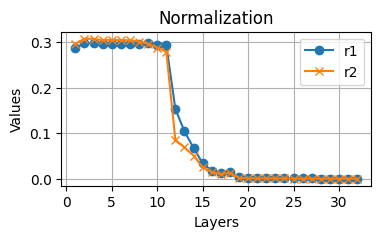

EuclideanDistance↓,ManhattanDistance↓,CosineSimilarity↑,ChebyshevDistance↓,MinkowskiDistance(p=3)↓
0.0834,0.2317,0.9965,0.0673,0.0713
PearsonCorrelation↑,SpearmanCorrelation↑,DTWDistance↓,MeanSquaredError↓
0.9946,0.9879,0.5472,0.0109


In [19]:

r1_subject = Needle_origin[1][3].squeeze()
r2_subject = Needle_near[1][3].squeeze()
print(r1_subject.shape, r2_subject.shape)
print("Origin vs Near")
calculate_distances(r1_subject, r2_subject)
calculate_corr(r1_subject, r2_subject)

Origin vs Far


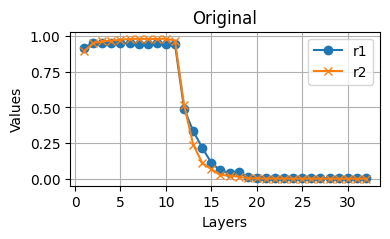

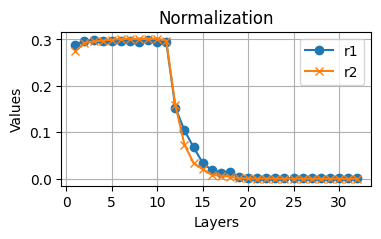

EuclideanDistance↓,ManhattanDistance↓,CosineSimilarity↑,ChebyshevDistance↓,MinkowskiDistance(p=3)↓
0.0543,0.1816,0.9985,0.0339,0.0424
PearsonCorrelation↑,SpearmanCorrelation↑,DTWDistance↓,MeanSquaredError↓
0.9980,0.9549,0.2840,0.0040


In [20]:

r1_subject = Needle_origin[1][3].squeeze()
r2_subject = Needle_far[1][6].squeeze()

print("Origin vs Far")

calculate_distances(r1_subject, r2_subject)
calculate_corr(r1_subject, r2_subject)


Origin vs Eiffel


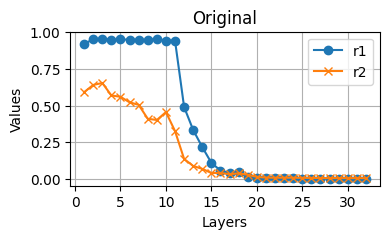

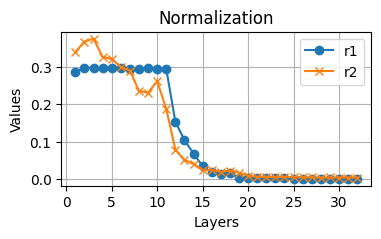

EuclideanDistance↓,ManhattanDistance↓,CosineSimilarity↑,ChebyshevDistance↓,MinkowskiDistance(p=3)↓
0.2131,0.7755,0.9773,0.1065,0.1495
PearsonCorrelation↑,SpearmanCorrelation↑,DTWDistance↓,MeanSquaredError↓
0.9619,0.9699,1.1915,0.0762


In [28]:

r1_subject = Needle_origin[1][3].squeeze()
r2_subject = Eiffel[1][5].squeeze()

print("Origin vs Eiffel")

calculate_distances(r1_subject, r2_subject)
calculate_corr(r1_subject, r2_subject)


Origin vs Berlin


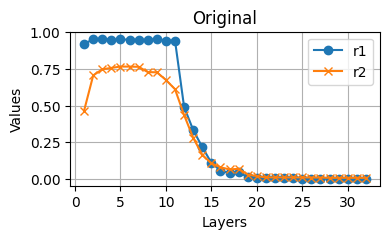

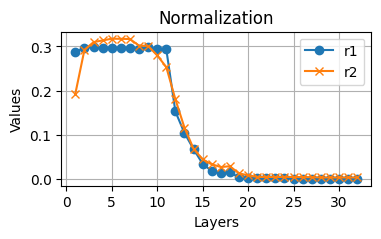

EuclideanDistance↓,ManhattanDistance↓,CosineSimilarity↑,ChebyshevDistance↓,MinkowskiDistance(p=3)↓
0.1196,0.4005,0.9928,0.0935,0.0985
PearsonCorrelation↑,SpearmanCorrelation↑,DTWDistance↓,MeanSquaredError↓
0.9878,0.9736,0.8714,0.0244


In [29]:

r1_subject = Needle_origin[1][3].squeeze()
r2_subject = Berlin[1][4].squeeze()

print("Origin vs Berlin")

calculate_distances(r1_subject, r2_subject)
calculate_corr(r1_subject, r2_subject)

Origin vs Sydney


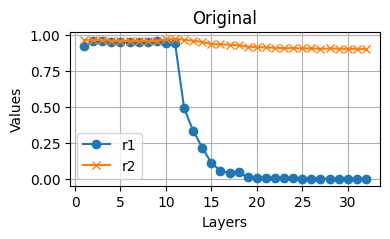

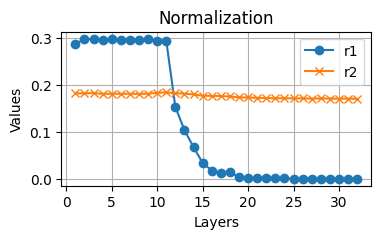

EuclideanDistance↓,ManhattanDistance↓,CosineSimilarity↑,ChebyshevDistance↓,MinkowskiDistance(p=3)↓
0.8146,4.4713,0.6682,0.1708,0.4675
PearsonCorrelation↑,SpearmanCorrelation↑,DTWDistance↓,MeanSquaredError↓
0.8916,0.9164,1.4488,0.2169


In [32]:

r1_subject = Needle_origin[1][3].squeeze()
r2_subject = Sydney[1][4].squeeze()

print("Origin vs Sydney")

calculate_distances(r1_subject, r2_subject)
calculate_corr(r1_subject, r2_subject)

Sydney Origin vs Sydney Near


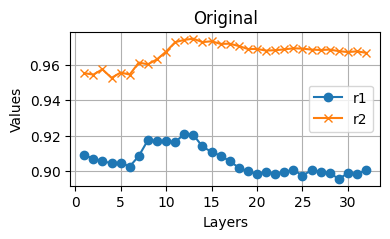

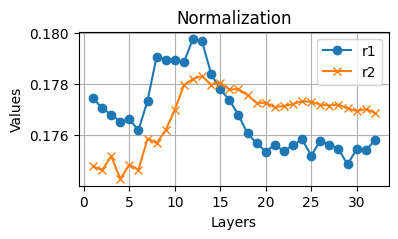

EuclideanDistance↓,ManhattanDistance↓,CosineSimilarity↑,ChebyshevDistance↓,MinkowskiDistance(p=3)↓
0.0100,0.0524,1.0000,0.0034,0.0059
PearsonCorrelation↑,SpearmanCorrelation↑,DTWDistance↓,MeanSquaredError↓
0.0806,0.0913,6.0042,1.8387


In [33]:

r1_subject = Sydney[1][1].squeeze()
r2_subject = Sydney_near[1][4].squeeze()

print("Sydney Origin vs Sydney Near")

calculate_distances(r1_subject, r2_subject)
calculate_corr(r1_subject, r2_subject)

Sydney Origin vs Sydney Far


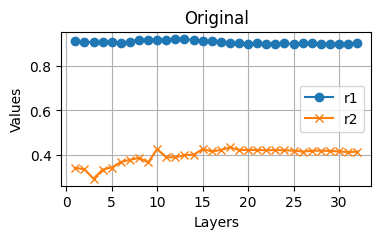

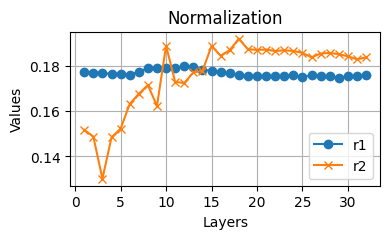

EuclideanDistance↓,ManhattanDistance↓,CosineSimilarity↑,ChebyshevDistance↓,MinkowskiDistance(p=3)↓
0.0883,0.4121,0.9961,0.0466,0.0594
PearsonCorrelation↑,SpearmanCorrelation↑,DTWDistance↓,MeanSquaredError↓
-0.2875,-0.3919,7.3697,2.5750


In [35]:

r1_subject = Sydney[1][1].squeeze()
r2_subject = Sydney_far[1][7].squeeze()

print("Sydney Origin vs Sydney Far")

calculate_distances(r1_subject, r2_subject)
calculate_corr(r1_subject, r2_subject)

Sydney Origin vs Eiffel


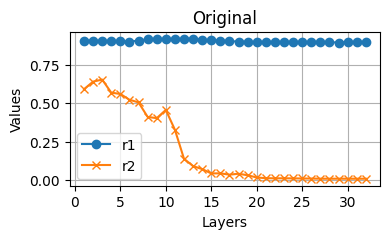

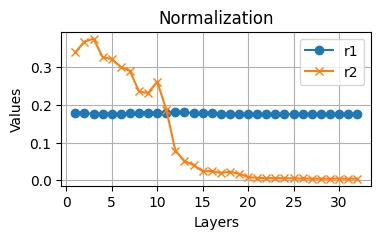

EuclideanDistance↓,ManhattanDistance↓,CosineSimilarity↑,ChebyshevDistance↓,MinkowskiDistance(p=3)↓
0.8546,4.6414,0.6349,0.1984,0.4912
PearsonCorrelation↑,SpearmanCorrelation↑,DTWDistance↓,MeanSquaredError↓
0.4119,0.7122,4.1984,1.1761


In [37]:
r1_subject = Sydney[1][1].squeeze()
r2_subject = Eiffel[1][5].squeeze()

print("Sydney Origin vs Eiffel")

calculate_distances(r1_subject, r2_subject)
calculate_corr(r1_subject, r2_subject)
